In [25]:
'''
Plot modeled sea ice variables forecasts

'''
%matplotlib inline
%load_ext autoreload
%autoreload
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import numpy.ma as ma
import pandas as pd
import struct
import os
import xarray as xr
import glob
import datetime
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns

import esio

# General plotting settings
sns.set_style('whitegrid')
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

#############################################################
# Load in Data
#############################################################
base_dir = r'/home/disk/sipn/nicway/data/'
fig_dir = r'/home/disk/sipn/nicway/public_html/sipn'
grid_dir = os.path.join(base_dir, 'grids')

# Load in Model
model='gfdlsipn'
runType='forecast'
gfdl_forecast = os.path.join(base_dir, 'model', model, runType, 'sipn_nc', '*.nc')
gfdl = xr.open_mfdataset(gfdl_forecast)
gfdl.rename({'nj':'x', 'ni':'y'}, inplace=True)

# Load in regional data
# Note minor -0.000004 degree differences in latitude
ds_region = xr.open_dataset(os.path.join(grid_dir, 'sio_2016_mask.nc'))
ds_region.set_coords(['lat','lon'], inplace=True);
ds_region.rename({'nx':'x', 'ny':'y'}, inplace=True);

#############################################################

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
gfdl.dims

Frozen(SortedKeysDict(OrderedDict([('ensemble', 12), ('fore_time_i', 12), ('y', 448), ('x', 304)])))

In [27]:
ds_region.dims

Frozen(SortedKeysDict(OrderedDict([('nregions', 21), ('x', 304), ('y', 448)])))

In [31]:
# Get regional averages
gfdl_reg = esio.agg_by_domain(da_grid=gfdl.sic, ds_region=ds_region)
gfdl_reg

<xarray.DataArray (nregions: 14, ensemble: 12, fore_time_i: 12)>
dask.array<shape=(14, 12, 12), dtype=float64, chunksize=(1, 12, 12)>
Coordinates:
  * ensemble      (ensemble) int64 1 2 3 4 5 6 7 8 9 10 11 12
    fore_time     (fore_time_i) datetime64[ns] 2018-03-01 2018-04-01 ...
  * fore_time_i   (fore_time_i) int64 0 1 2 3 4 5 6 7 8 9 10 11
    init_time     datetime64[ns] 2018-03-01
  * nregions      (nregions) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14
    region_names  (nregions) <U17 'Sea of Okhotsk   ' 'Bering           ' ...

In [29]:
# Aggregate over entire domain
gfdl_avg = (gfdl.sic*ds_region.area).sum(dim='x').sum(dim='y')/(10**6)
gfdl_avg

<xarray.DataArray (ensemble: 12, fore_time_i: 12)>
dask.array<shape=(12, 12), dtype=float64, chunksize=(12, 12)>
Coordinates:
  * ensemble     (ensemble) int64 1 2 3 4 5 6 7 8 9 10 11 12
    fore_time    (fore_time_i) datetime64[ns] dask.array<shape=(12,), chunksize=(12,)>
  * fore_time_i  (fore_time_i) int64 0 1 2 3 4 5 6 7 8 9 10 11
    init_time    datetime64[ns] ...

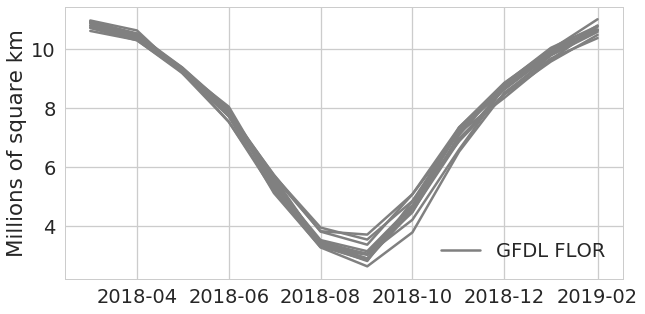

In [41]:
# Plot pan-Arctic sea ice extent
f = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 1, 1) # Observations
esio.plot_model_ensm(ds=gfdl_avg, axin=ax1, labelin='GFDL FLOR', color='grey', marker=None)
ax1.set_ylabel('Millions of square km')
plt.legend(loc='lower right') #bbox_to_anchor=(1.03, 1.05)
f.savefig(os.path.join(fig_dir,'panArcticSIC_LongRange_'+model+'_'+runType+'.png'),bbox_inches='tight',dpi=200)

In [34]:
gfdl_reg.nregions

<xarray.DataArray 'nregions' (nregions: 14)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])
Coordinates:
    init_time     datetime64[ns] 2018-03-01
  * nregions      (nregions) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14
    region_names  (nregions) <U17 'Sea of Okhotsk   ' 'Bering           ' ...

In [37]:
import itertools
cmap_reg = itertools.cycle(sns.color_palette("Set2", gfdl_reg.nregions.size))

In [38]:
cmap_reg

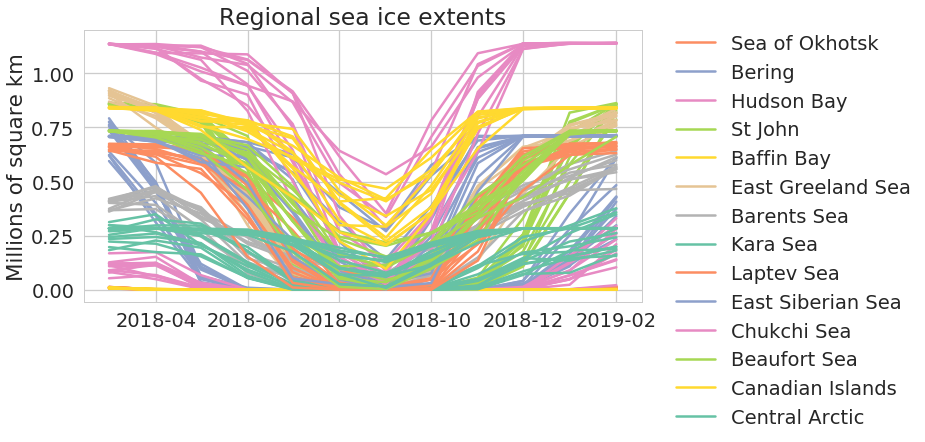

In [42]:
# Plot regional sea ice extents
f = plt.figure(figsize=(10,5))
ax1 = plt.subplot(1, 1, 1)
for cd in gfdl_reg.nregions:
    esio.plot_model_ensm(ds= gfdl_reg.sel(nregions=cd), color=next(cmap_reg),
                         axin=ax1, 
                         labelin=gfdl_reg.region_names.sel(nregions=cd).values,
                         marker=None)
ax1.set_title('Regional sea ice extents')
ax1.set_ylabel('Millions of square km')
plt.legend(bbox_to_anchor=(1.03, 1.05))
f.savefig(os.path.join(fig_dir,'panArcticSIC_LongRange_Regional_'+model+'_'+runType+'.png'),bbox_inches='tight',dpi=200)

In [43]:
# Set up plotting info
cmap_sic = matplotlib.colors.ListedColormap(sns.color_palette("Blues_r", 10))
cmap_sic.set_bad(color = 'lightgrey')

/home/disk/sipn/nicway/anaconda3/envs/esio/lib/python3.6/site-packages/dask/array/numpy_compat.py:48: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


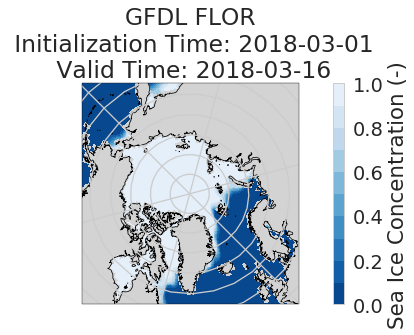

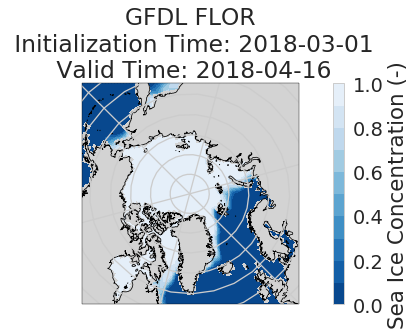

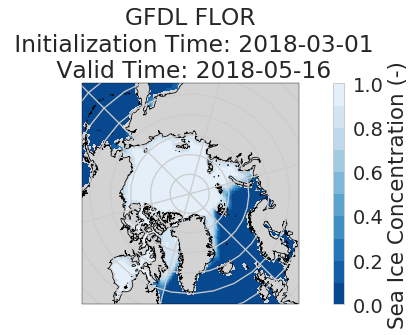

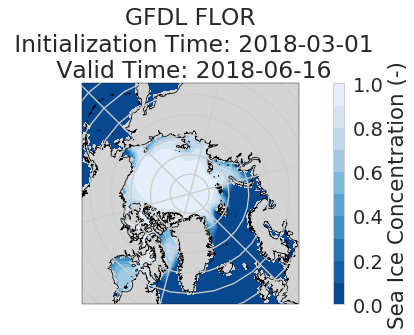

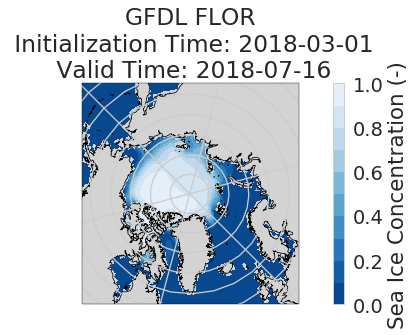

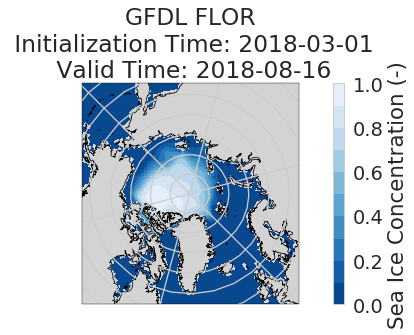

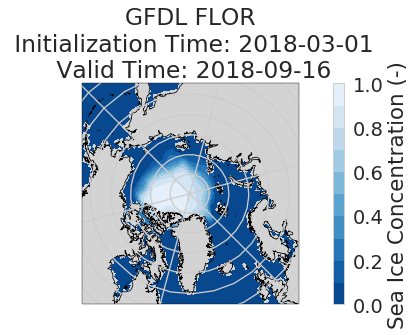

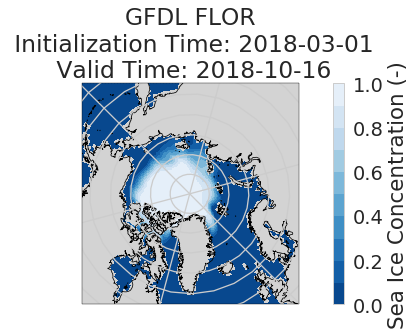

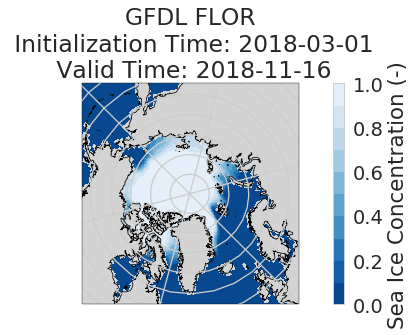

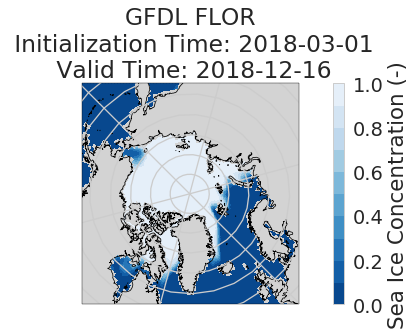

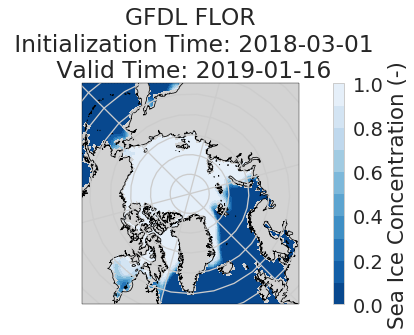

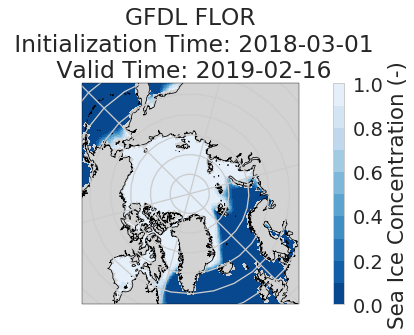

In [57]:
# Plot monthly sea ice concentration from ensemble mean

if 'init_time' in gfdl.dims:
    c_da = gfdl.sic.isel(init_time=init_time.size-1).mean(dim='ensemble')
else:
    c_da = gfdl.sic.mean(dim='ensemble')

for FT in gfdl.fore_time_i:
    (f, ax1) = esio.polar_axis()
    f.set_size_inches(10, 5)
    init_time =  pd.to_datetime( c_da.init_time.values).strftime('%Y-%m-%d')
    valid_time = pd.to_datetime( c_da.sel(fore_time_i=FT).fore_time.values + np.timedelta64(15,'D')).strftime('%Y-%m-%d')

    c_da.sel(fore_time_i=FT).plot.pcolormesh(ax=ax1, x='lon', y='lat', 
                                         transform=ccrs.PlateCarree(),
                                         cmap=cmap_sic,
                          vmin=0, vmax=1, cbar_kwargs={'label':'Sea Ice Concentration (-)'})
    ax1.set_title('GFDL FLOR\n Initialization Time: '+init_time+'\n Valid Time: '+valid_time)
    plt.tight_layout()
    f.savefig(os.path.join(fig_dir,'panArcticSIC_EnsembleMean_'+model+'_'+ runType+'_MonthLead_'+str(FT.values)+'.png'),bbox_inches='tight',dpi=200)
